# Overview

Using scraped data from ratebeer.com, I train a model here to predict average beer ratings for a given beer

In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import re
import pandas as pd
import numpy as np
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score

import string
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from collections import defaultdict


%matplotlib inline

df = pd.read_csv('data_conso.csv', encoding='iso-8859-1')

def av_wordlen(words):
    wordlist = words.split(' ')
    return np.mean([len(word) for word in wordlist])

df.shape

c:\users\avi\anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(5000, 8)

# Data Cleaning


It's rare that you'll find a clean dataset

In [2]:
#adjust the target variable
for i, value in enumerate(df['WEIGHTED']):
    try:
        float(str(value).split('/')[0])
    except:
        df.drop(i, inplace=True)

#this beer has a null rating; drop it from the dataset
df['WEIGHTED'] = df['WEIGHTED'].apply(lambda x: float(str(x).split('/')[0]))

In [3]:
#parse and impute values
df['ABV'] = df['ABV'].apply(lambda x: (str(x).strip('%- ')))
df['ABV'].replace('',np.nan, inplace=True)
df['ABV'] = df['ABV'].apply(lambda x: float(x))
df['ABV'] = df['ABV'].fillna(df['ABV'].mean())

df['LOG_ABV'] = np.log(df['ABV'])

df['Descr'] = df['Descr'].apply(lambda x: x.lower())

df['CALORIES'] = df['CALORIES'].fillna(df['CALORIES'].mean())

df['Title'] = df['Title'].apply(lambda x: x.split('(')[0])
df['Title'] = df['Title'].apply(lambda x: x.split('\r')[0])
df['Title_longest_word'] = df['Title'].apply(lambda x: max([len(i) for i in x.split(' ')]))
df['Title_shortest_word'] = df['Title'].apply(lambda x: min([len(i) for i in x.split(' ')]))
df['Title_words'] = df['Title'].apply(lambda x: len(x.split(' '))) 

df['Style'] = df['Style:'].apply(lambda x: x.split('/')[0])
df['Style'] = df['Style'].apply(lambda x: x.split('(')[0])
df['Style'] = df['Style'].apply(lambda x: x.lower().strip())

In [65]:
#Select the features with the highest correlations
df.corr()['WEIGHTED'].sort_values(ascending=False)

WEIGHTED               1.000000
LOG_ABV                0.527332
CALORIES               0.503974
ABV                    0.500146
Title_words            0.201007
Title_longest_word     0.107394
Title_shortest_word   -0.098747
Name: WEIGHTED, dtype: float64

In [4]:
#isolate description keywords

stemmer = SnowballStemmer("english", ignore_stopwords=True)

word_counts = defaultdict(int)
excl = set(string.punctuation)
stop = stopwords.words('english')

for val in df['Descr']:
    val2 = ''.join(ch for ch in val if ch not in excl)
    for word in val2.split(' '):
        if len(word) > 3 and word not in stop:
            word_counts[stemmer.stem(word)] += 1

word_tup =  sorted([(a,word_counts[a]) for a in word_counts], key=lambda x: x[1], reverse=True)[2:]


In [5]:
word_tup = list(filter(lambda x: x[1] > 100, word_tup))

keywords = [a[0] for a in word_tup]
best_words = []

for word in keywords:
    dat = pd.Series(df['Descr'].apply(lambda x: str(word) in x))
    if dat.corr(df['WEIGHTED'], method='pearson') > 0.1 and len(word) > 3:
        best_words.append(word)

for word in best_words:
    df[word] = df['Descr'].apply(lambda x: str(word) in x)

IBU is useless as a feature; less than 40% of the dataset even has a value for it

In [68]:
# If we want to see what happens when we consider IBU
'''
df['IBU'] = df['IBU'].apply(lambda x: ''.join([c for c in str(x) if c in '1234567890']))
df['IBU'].replace('', np.nan, inplace=True)
df['IBU'] = df['IBU'].apply(lambda x: float(x))
df['IBU'] = df['IBU'].fillna(0)''';

#IBU is basically useless: Only 38% of data even has a value
print(sum(1-df['IBU'].isnull())/len(df['IBU']))

len(df['Style'].unique())

0.381676335267


79

In [6]:
#get dummy variables and drop unnecessary columns

X=patsy.dmatrix('Place',data=df,return_type='dataframe')
df2 = pd.concat([df,X], axis=1)
X=patsy.dmatrix('Style',data=df,return_type='dataframe')

df2['Int'] = df2['Intercept']

cols_to_drop = ['Title', 'Place', 'Style', 'Style:', 'Descr', 'Intercept', 'Int', 'ABV', 'IBU', 'CALORIES']
#CALORIES and ABV are highly correlated

df2 = pd.concat([df2,X], axis=1)
df2 = df2.drop(cols_to_drop, axis=1)


# Exploration and Feature engineering

Curious: Which state gets the best-rated beer?

In [52]:
#Which states are the most popular for beer?
df.groupby('Place')['WEIGHTED'].mean().sort_values(ascending=False).head(15)

Place
California         3.7796
Michigan           3.6891
Florida            3.6691
Indiana            3.6536
Alaska             3.6465
Ohio               3.6132
Illinois           3.5849
Oregon             3.5718
New York           3.5281
South  Carolina    3.5032
Oklahoma           3.4904
North Carolina     3.4749
Georgia            3.4630
Vermont            3.4627
Delaware           3.4624
Name: WEIGHTED, dtype: float64

How are ratings distributed?

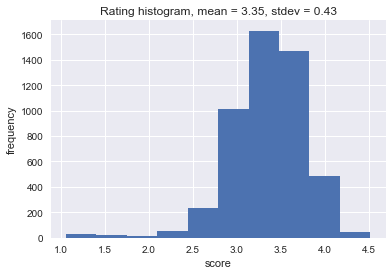

In [70]:
df['WEIGHTED'].hist()
np.std(df['WEIGHTED'])
plt.xlabel('score')
plt.ylabel('frequency')
plt.title('Rating histogram, mean = ' + str("{0:.2f}".format(np.mean(df['WEIGHTED']))) + ', stdev = ' + str("{0:.2f}".format(np.std(df['WEIGHTED']))));

In [81]:
#sample so the pairplot isn't incomprehensibly dense
df_dummy = df.sample(200)
sns.pairplot(df_dummy[['ABV', 'LOG_ABV', 'CALORIES', 'WEIGHTED']]);

ABV is one of my strongest features

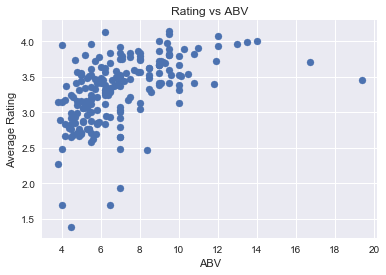

In [139]:
df_dummy = df.sample(200)
plt.scatter(df_dummy['ABV'], df_dummy['WEIGHTED'])
plt.xlabel('ABV')
plt.ylabel('Average Rating')
plt.title('Rating vs ABV')

In [380]:
len(df[df.Style == 'sour'])

108

To simplify the model, pick only the strongest features

In [138]:
#Select the features with the highest correlations

feat_values = df2.corr()['WEIGHTED'].sort_values(ascending=False)
best_feats = feat_values.apply(lambda x: np.abs(x))
best_feats = feat_values.sort_values(ascending=False)[best_feats > 0.02].index
feat_values

WEIGHTED                      1.000000
LOG_ABV                       0.527332
Style[T.imperial stout]       0.320847
barrel                        0.272299
imperi                        0.254078
stout                         0.238617
Title_words                   0.201007
Style[T.imperial ipa]         0.181751
bourbon                       0.180545
doubl                         0.154693
coffe                         0.145631
Place[T.California]           0.143037
vanilla                       0.140101
chocol                        0.131358
releas                        0.129348
roast                         0.128255
Style[T.barley wine]          0.128217
intens                        0.127841
dark                          0.127534
month                         0.127259
black                         0.124196
wine                          0.123245
bottl                         0.113520
batch                         0.113310
Place[T.Michigan]             0.113001
bean                     

In [14]:
x.shape

(4999, 115)

# Model Building

Now the fun part

In [146]:
#get average behavior for the model
df2 = shuffle(df2)
y = df2['WEIGHTED']
x = df2[[col for col in best_feats if col != 'WEIGHTED']]

lr2 = Ridge(alpha=0.01, normalize=True)

scores = cross_val_score(lr2, x, y, cv=20, scoring='neg_mean_squared_error')
scores_2 = cross_val_score(lr2, x, y, cv=20, scoring='r2')
print(-np.mean(scores), np.mean(scores_2))

#without keywords: 0.622, 0.069
#with keywords: .630, 0.0673

0.0671531564699 0.631238965278


In [158]:
#Define model variables
df2 = shuffle(df2)
y = df2['WEIGHTED']
x = df2[[col for col in best_feats if (col != 'WEIGHTED')]]

lr = Ridge(alpha=0.01, normalize=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Fit the model against the training data
lr.fit(X_train, y_train)

# Evaluate the model against the testing data
print('Train r2:', lr.score(X_train, y_train))
print('Test r2:', lr.score(X_test, y_test))

print('Train mse: ',mean_squared_error(y_train, lr.predict(X_train)))
print('Test mse: ', mean_squared_error(y_test, lr.predict(X_test)))

Train r2: 0.652865068071
Test r2: 0.653223691965
Train mse:  0.0645693955534
Test mse:  0.0632964579438


In [156]:
#save the model for later

import pickle as pkl

data = {'data': df, 'x':x, 'y':y, 'model': lr}

with open('beer_model.pkl', 'wb') as picklefile:
    pkl.dump(data, picklefile)

# Model Evaluation

In [20]:
list(zip(X_test.columns, lr.coef_)) #weights for individual features

sorted([a for a in list(zip(X_test.columns, lr.coef_)) if np.abs(a[1]) > 0.03], key = lambda x: x[1], reverse=True)


[('Style[T.lambic style - gueuze]', 0.35424845416120865),
 ('Place[T.California]', 0.34349862885614946),
 ('LOG_ABV', 0.27139482200787352),
 ('Place[T.Michigan]', 0.24346786330366335),
 ('Style[T.imperial stout]', 0.23163792451099802),
 ('Style[T.grodziskie]', 0.2168551900048207),
 ('Place[T.Florida]', 0.20186298471115011),
 ('Style[T.baltic porter]', 0.19796561766859058),
 ('Place[T.Oregon]', 0.1965658275680883),
 ('Place[T.Indiana]', 0.19641402257574911),
 ('Place[T.Ohio]', 0.17066344435578362),
 ('Style[T.foreign stout]', 0.16521978594294295),
 ('Style[T.sour]', 0.1643874506060691),
 ('Place[T.Alaska]', 0.16295915250100684),
 ('Place[T.New York]', 0.16049656347025737),
 ('Place[T.Illinois]', 0.14886979159396513),
 ('Style[T.sour red]', 0.14160444809080944),
 ('Place[T.Vermont]', 0.13919080225589472),
 ('Style[T.imperial porter]', 0.13746265445703548),
 ('Style[T.black ipa]', 0.13497724498408048),
 ('Style[T.imperial ipa]', 0.12701330262585797),
 ('barrel', 0.12407719785528881),
 ('P

How is the error distributed in the predictions?

Looks pretty normal; Seems that the linear regression assumptions are more-or-less satisfied

With a standard deviation of 0.25 and a normal distribution:  
**This model is accurate to within half a star (95% confidence)**

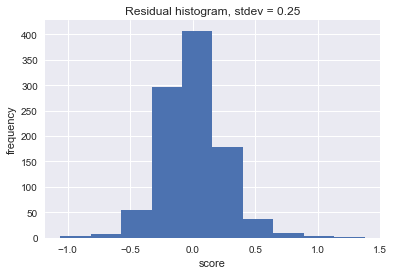

In [159]:
#Plotting histogram of residuals: checking the linear regression assumptions
resid = lr.predict(X_test)-y_test
plt.hist(resid);
plt.xlabel('score');
plt.ylabel('frequency');
plt.title('Residual histogram, stdev = ' + str("{0:.2f}".format(np.std(resid))));

Heteroskedasticity (sp?) is satisfied too

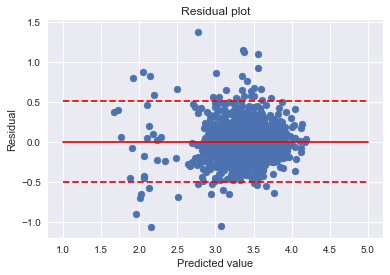

In [160]:
plt.scatter(lr.predict(X_test), resid);
plt.plot([1,5], [0,0], 'r');
plt.plot([1,5], [2*np.std(resid), 2*np.std(resid)], 'r--')
plt.plot([1,5], [-2*np.std(resid), -2*np.std(resid)], 'r--')
plt.xlabel('Predicted value')
plt.ylabel('Residual')
plt.title('Residual plot');
#Residual plot

Errors aren't correlated

0.00031264001309954173

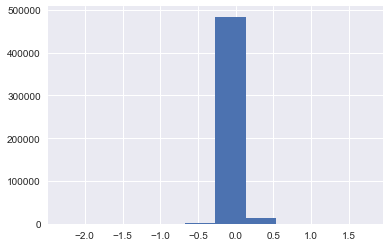

In [23]:
#are the errors correlated??

from itertools import product

eiej = [ei*ej 
        for (i, ei), (j, ej) in product(enumerate(resid), repeat=2)
        if i < j]

plt.hist(eiej);
np.mean(eiej) #No.

How do the predictions look?

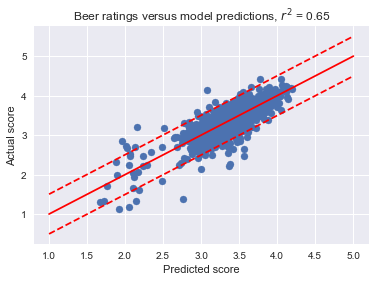

In [161]:
xplt = lr.predict(X_test)
yplt = y_test

plt.scatter(xplt, yplt)
plt.plot(np.arange(1,6), np.arange(1,6), 'r');
plt.plot(np.arange(1,6), np.arange(1,6) + 2*np.std(resid), 'r--')
plt.plot(np.arange(1,6), np.arange(1,6) - 2*np.std(resid), 'r--')
plt.xlabel('Predicted score')
plt.ylabel('Actual score')

title = r'Beer ratings versus model predictions, $r^2$ = ' + "{0:.2f}".format(lr.score(X_test, y_test))
plt.title(title);


In [152]:
#So how confident are we in our accuracy to 2 standard deviations??
len(resid[(resid <= 2*np.std(resid)) & (resid >= -2*np.std(resid))])/len(resid)

0.947

# Other

In [43]:
#compute adjusted r^2

n = x.shape[0]
k = x.shape[1]

adjr2 = 1-(n-1)/(n-k-1)*(1-lr.score(X_test,y_test))

adjr2 #marginally less than normal r^2. Nothing to worry about

0.63969077077018466

In [44]:
#Which styles are the most popular for beer?
a = df.groupby('Style')['WEIGHTED'].count().sort_values(ascending=False)
a = a[a > 100]
b = df.groupby('Style')['WEIGHTED'].mean().sort_values(ascending=False).head(10)

b
#there's no consistent way to get the best styles; too subjective

Style
imperial stout           3.846667
imperial porter          3.703800
lambic style - gueuze    3.700000
barley wine              3.679926
sour red                 3.678846
imperial ipa             3.661051
baltic porter            3.657273
sour                     3.626574
foreign stout            3.625556
lambic style - fruit     3.608000
Name: WEIGHTED, dtype: float64